In [2]:
import os
import sys
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams
import io
import numpy as np 
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from sklearn.decomposition import NMF, LatentDirichletAllocation



PDF_PATH = os.path.join('data', 'justice','pdfs')
PDF_NAMES = os.listdir(PDF_PATH)
CORPUS_PATH = os.path.join('data','justice','txt')

# CORPUS_PATH = os.path.join('data', 'austen-brontë-split')
# print(PDF_PATH)
# print(PDF_NAMES)
# print(CORPUS_PATH)

#make a list of pdf files names
#go through each of them and write them to the same directory as a text file 

pdffilenames = sorted([os.path.join(PDF_PATH, fn) for fn in os.listdir(PDF_PATH)])
# print(pdffilenames)


def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

#     print(data)
    return data

# if __name__ == '__main__':
# pdfparser(CORPUS_PATH)  


def pdfConverter(arrayOfFullFileNames, arrayOfPDFNames, destPath):
    for i in range(len(arrayOfFullFileNames)):
#         print(i)
#         print('Creating new text file') 
        if not str(arrayOfPDFNames[i]).startswith('.'):
            name = arrayOfPDFNames[i] + str(i) + '.txt'
#             print(name)
            try:
                content = pdfparser(arrayOfFullFileNames[i])
                contenttwo = str(content)
                finalFile = os.path.join('data','justice','raw', name)
#                 print(finalFile)
                file = open(finalFile,'w')
#                 print(file)
                file.write(str(contenttwo))
                file.close()
            except:
                print('Something went wrong! Can\'t tell what?')
                sys.exit(0) # quit Python
        
        
pdfConverter(pdffilenames,PDF_NAMES,CORPUS_PATH) 


In [3]:
#now delete dot files from that directory for cleanup
# arrayOfFiles = 
# textFiles = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

# for i in range(len(textFiles)):
#     print(textFiles)
#     print(i)
#     print(textFiles[i])
#     if not str(textFiles[i]).startswith('.'):
#         print(i)
#         print(textFiles[i])
    #   filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

In [4]:
filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])
# print(filenames)
# print(len(filenames))

In [5]:
vectorizer = text.CountVectorizer(input='filename', stop_words='english', min_df=5, max_df = 0.85)

In [6]:
dtm = vectorizer.fit_transform(filenames).toarray()
vocab = np.array(vectorizer.get_feature_names())
# print(vocab)

In [7]:
print(len(vocab))


3697


In [8]:
dtm.shape

(115, 3697)

In [9]:
num_topics = 20
num_top_words = 10
clf = decomposition.NMF(n_components=num_topics, random_state=1)

print(clf)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)


In [10]:
doctopic = clf.fit_transform(dtm)

In [11]:
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

# print(topic_words)

In [12]:
doctopic = doctopic / np.sum(doctopic, axis=0, keepdims=True)
print(clf)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)


In [13]:
document_names = [] 

for fn in filenames:
    basename = os.path.basename(fn)
    name, ext = os.path.splitext(basename)
    name = name.rstrip('0123456789')
    document_names.append(name)
# print(document_names)

In [18]:
# print(clf)
document_names = np.asarray(document_names)
doctopic_orig = doctopic.copy()
num_groups = len(set(document_names))
# print(num_groups)
# print(doctopic.copy)
doctopic_grouped = np.zeros((num_groups, num_topics))
print(num_groups)
# print(doctopic_grouped)

# for i, name in enumerate(sorted(set(document_names))):
#     doctopic_grouped[i, :] = np.mean(doctopic[document_names == name, :], axis=0)

#     doctopic = doctopic_grouped

documents = sorted(set(document_names))
# print(documents)
# print(doctopic)

top_four_topics_total = []
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:4]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(documents[i], top_topics_str))
#     print(i)
#     print(top_topics_str)
    top_topics_split = top_topics_str.split(' ')
#     print(top_topics_split)
    top_four_topics_total.extend(top_topics_split)


73
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15-0100 (Nonprofit Hospital Pay).pdf: 7 12 14 9
15-0101 (Affordable Healthcare).pdf: 7 16 11 18
15-0102 (Nonprofit Hospital Healthcare).pdf: 7 18 11 17
15-0103 (Marijuana)_1.pdf: 4 17 18 9
15-0104 (Marijuana)_0.pdf: 17 18 5 16
15-0105 (Minimum Wage)_0.pdf: 12 18 19 8
15-0106 (Sales Tax on Political Advertisements V2).pdf: 18 17 15 19
15-0107 (Redirect HighSpeed Rail Funds to Water Projects)_0.pdf: 10 1 16 19
15-0108 (Electronic Voting)_0.pdf: 13 3 15 16
15-0109 (High Speed Rail)_0.pdf: 10 17 12 15
15-0110 (Construction-Related Accessibility Claims)_0.pdf: 16 13 14 17
15-0111 (Hospital Pay)_0.pdf: 7 12 15 14
15-0112 (Secret Ballot).pdf: 13 15 3 19
15-0113 (Disability Accessibility Violations).pdf: 16 15 12 13
15-0114 (Repeal Charter Schools)_0.pdf: 18 10 13 19
15-0115 (Temporary Tax Incr

IndexError: list index out of range

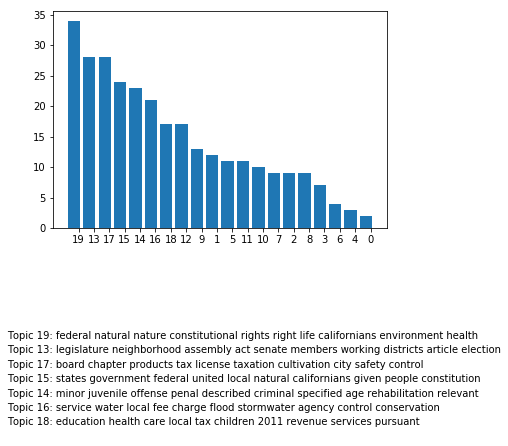

In [16]:
#make a histogram of this all
# print(top_four_topics_total)
#make a giant array of top topics for all the documents
counts = Counter(top_four_topics_total)
labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1]

# rearrange 
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.3

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)

figtext(.02, -0.3, "Topic 19: federal natural nature constitutional rights right life californians environment health\n")
figtext(.02, -0.35, "Topic 13: legislature neighborhood assembly act senate members working districts article election\n")

figtext(.02, -0.4, "Topic 17: board chapter products tax license taxation cultivation city safety control\n")

figtext(.02, -0.45, "Topic 15: states government federal united local natural californians given people constitution\n")


figtext(.02, -0.5, "Topic 14: minor juvenile offense penal described criminal specified age rehabilitation relevant\n")

figtext(.02, -0.55, "Topic 16: service water local fee charge flood stormwater agency control conservation\n")
figtext(.02, -0.6, "Topic 18: education health care local tax children 2011 revenue services pursuant\n")


plt.show()

In [66]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:20])))

Topic 0: person vehicle department 17 10 pursuant subdivision program violation date
Topic 1: water 000 projects division pursuant funds public dollars agency million
Topic 2: property replacement value original dwelling year base subdivision claimant person
Topic 3: ballot mail vote elections election voter official commission electronic pursuant
Topic 4: marijuana division use products subdivision department person pursuant act tax
Topic 5: pursuant subdivision vehicle tax transportation department year program funds fiscal
Topic 6: information consumer personal business 1798 purposes commercial act privacy including
Topic 7: hospital nonprofit corporation compensation medical entity subdivision person covered group
Topic 8: water 000 projects available pursuant funds division million dollars resources
Topic 9: department pursuant person vendor commencing chapter article purchaser licensed transaction
Topic 10: water authority storage chapter public bonds 15 project facilities ground

In [68]:
#try to display topics with context
print(clf)

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('Topic')
        print(topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
no_topics = 20


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(filenames)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


nmf_model = clf.fit(tfidf)
print(nmf_model)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_


tf_vectorizer = vectorizer
tf = tf_vectorizer.fit_transform(filenames)
tf_feature_names = tf_vectorizer.get_feature_names()



no_top_words = 8
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, filenames, no_top_words, no_top_documents)


NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)
NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)
Topic
0
0034 revenue bond tax 17 pdf7 pdf6 pdf34
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf72.txt
data/justice/txt/17-0034 (Tax and Bond Revenue)_0.pdf73.txt
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf6.txt
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf34.txt
Topic
1
gas car 0033 tax _0 repeal 0004 17
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf71.txt
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf33.txt
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf5.txt
data/justice/txt/17-0004 (Repeal Gas Tax)_0.pdf42.txt
Topic
2
quot 16 referendum ab sb pdf35 pdf30 pdf32
data/justice/txt